# Домашнее задание: GAN и Style Transfer

Суркис Антон (Stepik id: [83694640](https://stepik.org/users/83694640))

Выбранный метод: Neural Style Transfer с двумя стилями на разных частях картинки

Большая часть кода совпадает с кодом из [туториала PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html).
Остальной &mdash; прокомментирован.

Ссылка на GitHub с использованными файлами: https://github.com/asurkis/dls-homework-19-nst

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch import nn, optim
from PIL import Image
from torchvision import transforms, models
from tqdm.autonotebook import tqdm, trange
from IPython.display import clear_output

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 512 if torch.cuda.is_available() else 128

In [3]:
loader = transforms.Compose([transforms.Resize(imsize),
                             transforms.CenterCrop(imsize),
                             transforms.ToTensor()])
def image_loader(path):
    image = Image.open(path)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Можно набрать другие изображения
style_image_1 = image_loader('style1.jpg')
style_image_2 = image_loader('style2.jpg')
content_image = image_loader('content.jpg')

# Маска черно-белая, т.к. единственный канал отвечает
# за положение между двумя стилями
mask_image = transforms.Grayscale()(image_loader('mask.png'))

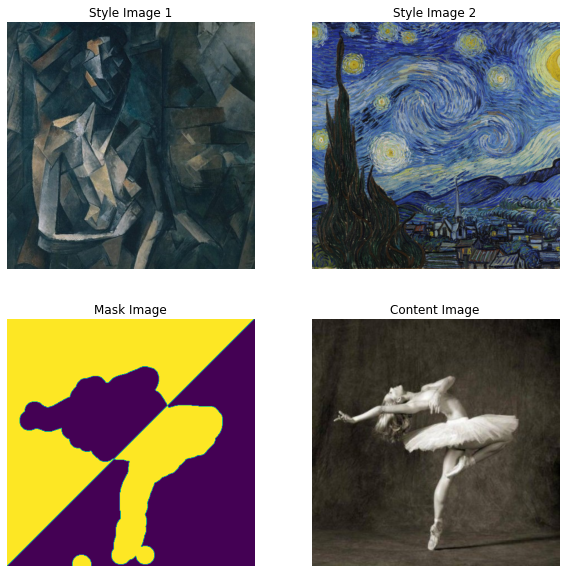

In [4]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None, axis=plt):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    axis.axis('off')
    axis.imshow(image)
    if title is not None:
        axis.set_title(title)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 10)
imshow(style_image_1, title='Style Image 1', axis=axes[0][0])
imshow(style_image_2, title='Style Image 2', axis=axes[0][1])
imshow(mask_image, title='Mask Image', axis=axes[1][0])
imshow(content_image, title='Content Image', axis=axes[1][1])
fig.show()

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(input):
    batch_size, channels, width, height = input.size()
    features = input.view(batch_size * channels, width * height)
    G = torch.mm(features, features.t())
    return G.div(batch_size * channels * width * height)

# Простой StyleLoss оставим
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature)
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class TwoStyleLoss(nn.Module):
    def __init__(self, target_feature_1, target_feature_2, mask):
        super(TwoStyleLoss, self).__init__()
        # Нужно анализировать оба стиля целиком
        self.target1 = gram_matrix(target_feature_1)
        self.target2 = gram_matrix(target_feature_2)
        self.mask = mask

    def forward(self, input):
        # Метод смешивания стилей: домножение _входного_ изображения
        # на маску и на инвертированную маску.
        # Таким образом стили будут анализироваться целиком,
        # что важно для их соблюдения, но те пиксели изображения,
        # которые не должны быть затронуты стилем,
        # будут иметь нулевой вклад в функцию потерь и ее градиент,
        # а потому не будут меняться.

        # В маске 0 -- первый стиль, а 1 -- второй,
        # то прямая маска -- по второму стилю, а инвертированная -- по первому
        G1 = gram_matrix(input * (1 - self.mask))
        G2 = gram_matrix(input * self.mask)
        self.loss = F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)
        return input

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
    def forward(self, image):
        return (image - self.mean) / self.std

In [9]:
content_layers_default = ['Conv2d_4']
style_layers_default = ['Conv2d_{}'.format(i + 1) for i in range(5)]

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_image_1, style_image_2, mask_image, content_image,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
        elif isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)
        name = '{}_{}'.format(layer.__class__.__name__, i)
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module('ContentLoss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            target_feature_1 = model(style_image_1).detach()
            target_feature_2 = model(style_image_2).detach()
            _, _, w, h = target_feature_1.size()
            mask = transforms.Resize((w, h))(mask_image).detach()
            style_loss = TwoStyleLoss(target_feature_1, target_feature_2, mask)
            model.add_module('TwoStyleLoss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
    
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss):
            break
        # Оставим на случай, если кто-то захочет добавить обычные StyleLoss
        if isinstance(model[i], StyleLoss):
            break
        if isinstance(model[i], TwoStyleLoss):
            break
    
    model = model[:(i + 1)]
    return model, style_losses, content_losses

In [10]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_image, style_image_1, style_image_2, mask_image, input_image,
                       content_layers=content_layers_default,
                       style_layers=style_layers_default,
                       num_steps=300, style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std,
        style_image_1, style_image_2, mask_image, content_image,
        content_layers=content_layers,
        style_layers=style_layers)
    optimizer = optim.LBFGS([input_image.requires_grad_()])

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_image.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_image)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('run {}:'.format(run))
                print('Style loss: {}'.format(style_score.item()))
                print('Content loss: {}'.format(content_score.item()))
                print()
            
            return style_score + content_score
        optimizer.step(closure)
    input_image.data.clamp_(0, 1)
    return input_image

In [11]:
# Добавим немного шума ко входу
input_image = content_image.clone() + 0.01 * torch.randn_like(content_image)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image_1, style_image_2,
                            mask_image, input_image.clone(),
                            style_layers=['Conv2d_{}'.format(i) for i in range(9)],
                            content_layers=['Conv2d_{}'.format(i) for i in range(9, 17)])

run [50]:
Style loss: 1316.403564453125
Content loss: 220.81643676757812

run [100]:
Style loss: 363.134521484375
Content loss: 181.84632873535156

run [150]:
Style loss: 190.97531127929688
Content loss: 148.2821807861328

run [200]:
Style loss: 140.21409606933594
Content loss: 131.33738708496094

run [250]:
Style loss: 117.78353881835938
Content loss: 120.99256896972656

run [300]:
Style loss: 104.11709594726562
Content loss: 114.5542221069336



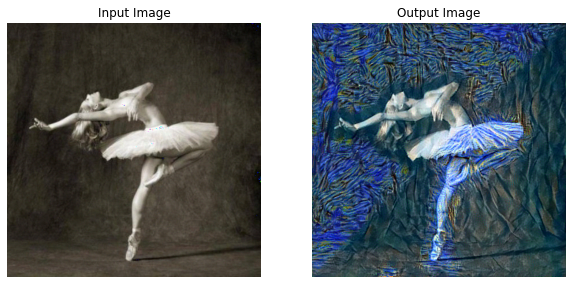

In [12]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 10)
imshow(input_image, title='Input Image', axis=axes[0])
imshow(output, title='Output Image', axis=axes[1])

Можно заметить, что применяются 2 стиля по маске, при этом контент остается различимым в рамках одного стиля.